In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import compression.score.score as score
from scipy.linalg import block_diag
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
### SET UP THE PRIOR ###

# number of nuisance parameters: must match number of photo-z bins
nz = 10

# Prior over theta
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

# Prior over eta (nuisances)
eta_lower = np.ones(nz)*-0.1
eta_upper = np.ones(nz)*0.1
eta_mean = np.zeros(nz)
eta_covariance = np.eye(nz)*0.05**2
eta_prior = priors.TruncatedGaussian(eta_mean, eta_covariance, eta_lower, eta_upper)

# Joint prior over nuisances and interesting parameters
joint_lower = np.concatenate([lower, eta_lower])
joint_upper = np.concatenate([upper, eta_upper])
joint_mean = np.concatenate([prior_mean, eta_mean])
joint_covariance = block_diag(prior_covariance, eta_covariance)
joint_prior = priors.TruncatedGaussian(joint_mean, 
                                       joint_covariance,
                                       joint_lower,
                                       joint_upper)

In [3]:
### SET UP THE SIMULATOR ###

# import tomographic n(z)
pz = pickle.load(open('simulators/cosmic_shear/pz_euclid.pkl', 'rb'))

# Set up the tomography simulations
CosmicShearSimulator = cosmic_shear.TomographicCosmicShearPhotoz(pz = pz, lmin = 10, lmax = 3000, n_ell_bins = 10, sigma_e = 0.3, nbar = 30, Area = 15000)

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args, batch):
    
    return CosmicShearSimulator.simulate(theta, seed)
simulator_args = None

In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Expected support of Wishart likelihood (fiducial inverse power spectrum)
C = CosmicShearSimulator.power_spectrum(theta_fiducial)
Cinv = np.array([np.linalg.inv(C[l,:,:]) for l in range(CosmicShearSimulator.n_ell_bins)])

# Degrees of freedom (effective number of modes per band power)
nl = CosmicShearSimulator.nl

# Calculate derivatives of the expected power spectrum
h = np.array(abs(theta_fiducial))*0.05
dCdt = CosmicShearSimulator.compute_derivatives(theta_fiducial, h)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Wishart(theta_fiducial, nl, Cinv, dCdt, prior_mean=joint_mean, prior_covariance=joint_covariance)

# Pull out Fisher matrix inverse
Finv = Compressor.Finv

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args = None

In [5]:
# The data vector: import or otherwise simulate for testing
data = compressor(simulator(theta_fiducial, 0, simulator_args), compressor_args)

In [6]:
# Create the neural density estimator (MAF)
MAF = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=15, n_outputs=15, n_hiddens=[50,50], 
                                               n_mades=5, act_fun=tf.tanh)

# Create the DELFI object
DelfiMAF = delfi.Delfi(data, joint_prior, MAF, Finv, theta_fiducial, 
                       param_limits = [joint_lower, joint_upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s', 'b_1', 'b_2', 'b_3', 'b_4', 'b_5', 'b_6', 'b_7', 'b_8', 'b_9', 'b_10'], 
                       results_dir = "simulators/cosmic_shear/results_nuisances/maf")

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))

Sampling approximate posterior...
Done.


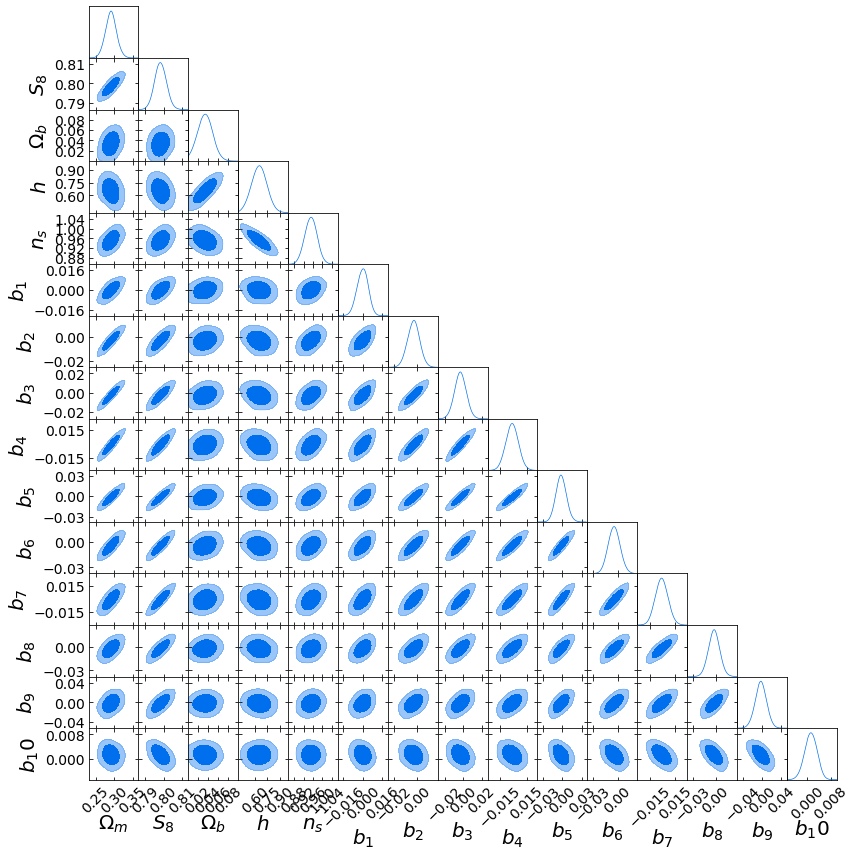

In [7]:
# Do the Fisher pre-training
DelfiMAF.fisher_pretraining()

HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


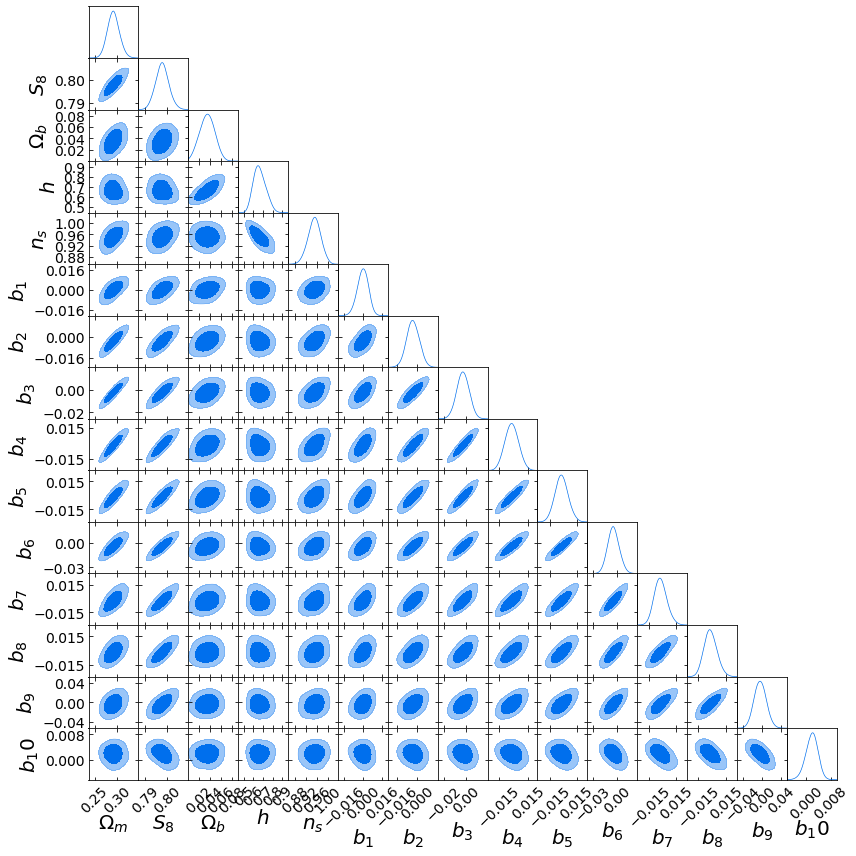

Population 1/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_MASTER/delfi/simulators/cosmic_shear/cosmic_shear.py:258: RuntimeWarning: invalid value encountered in log
  logpkz = np.log(cosmo.pk(np.exp(logk), z2a(z)))


Simulator returns exception for parameter values: [ 0.27033278  0.7953929   0.0575675   0.95743919  0.89056652 -0.00698405
 -0.01058925 -0.00866818 -0.01450824 -0.00822498 -0.00781686 -0.00682066
  0.00742366 -0.00525083 -0.00493016] (rank 0)


HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


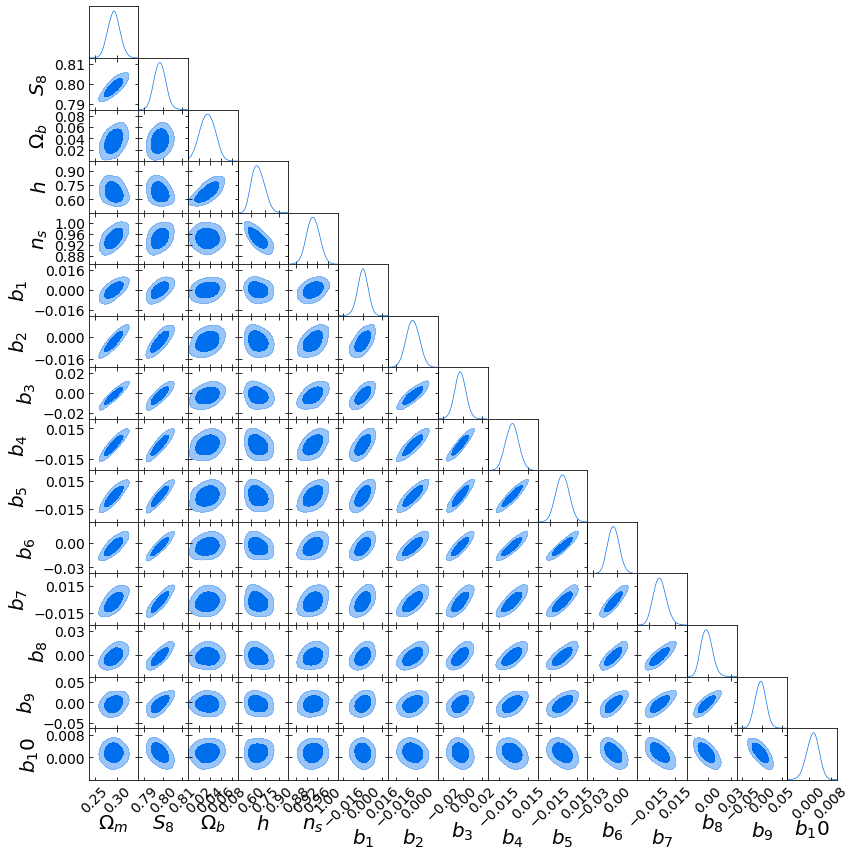

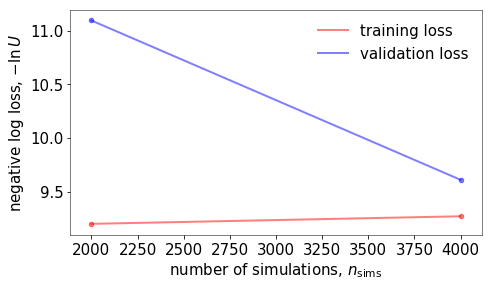

Population 2/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


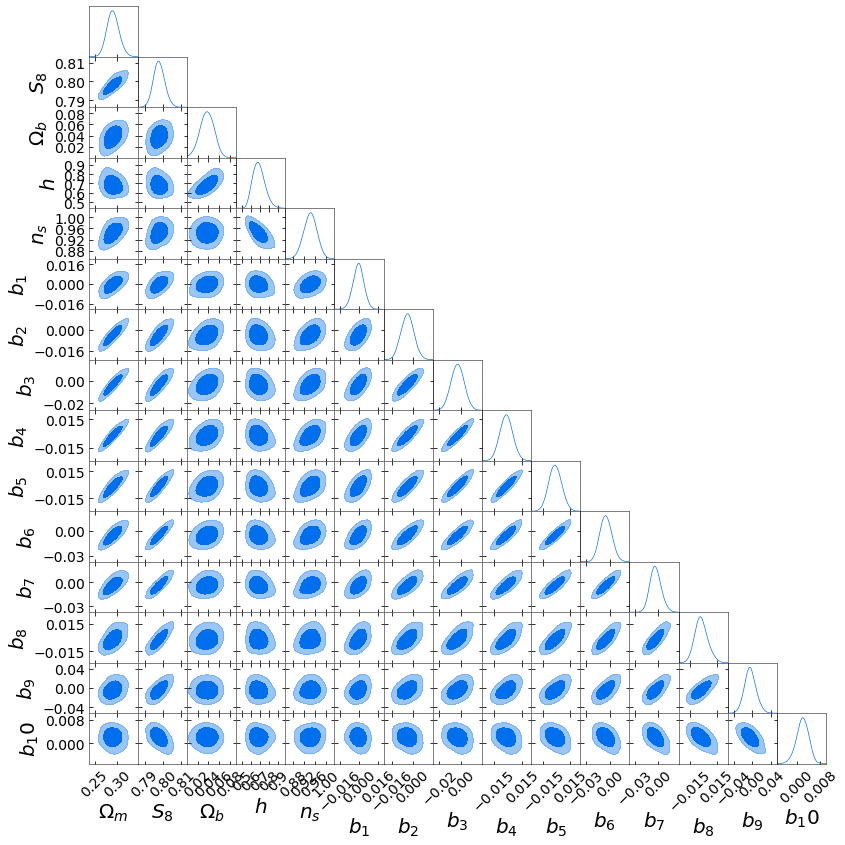

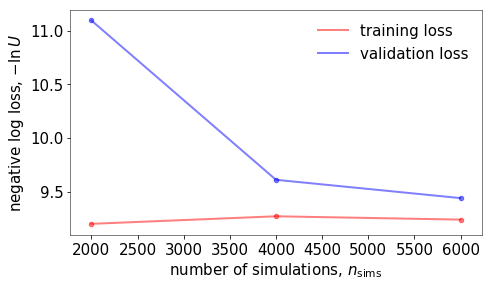

Population 3/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


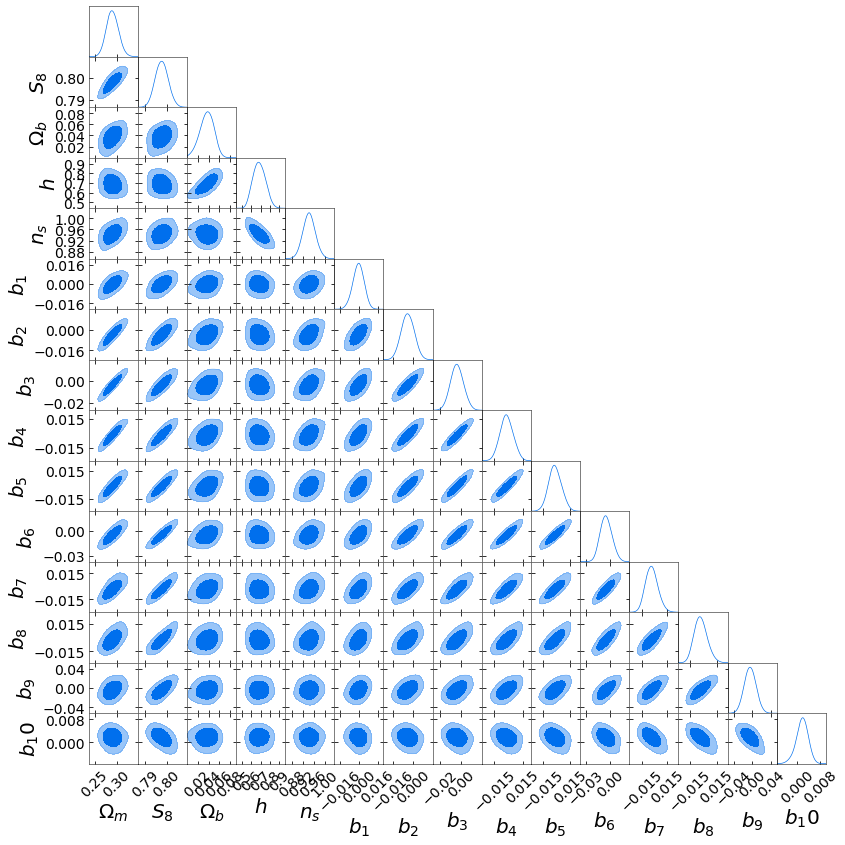

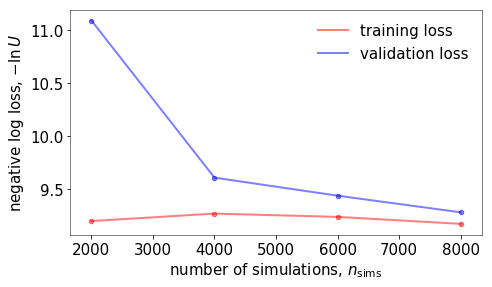

Population 4/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


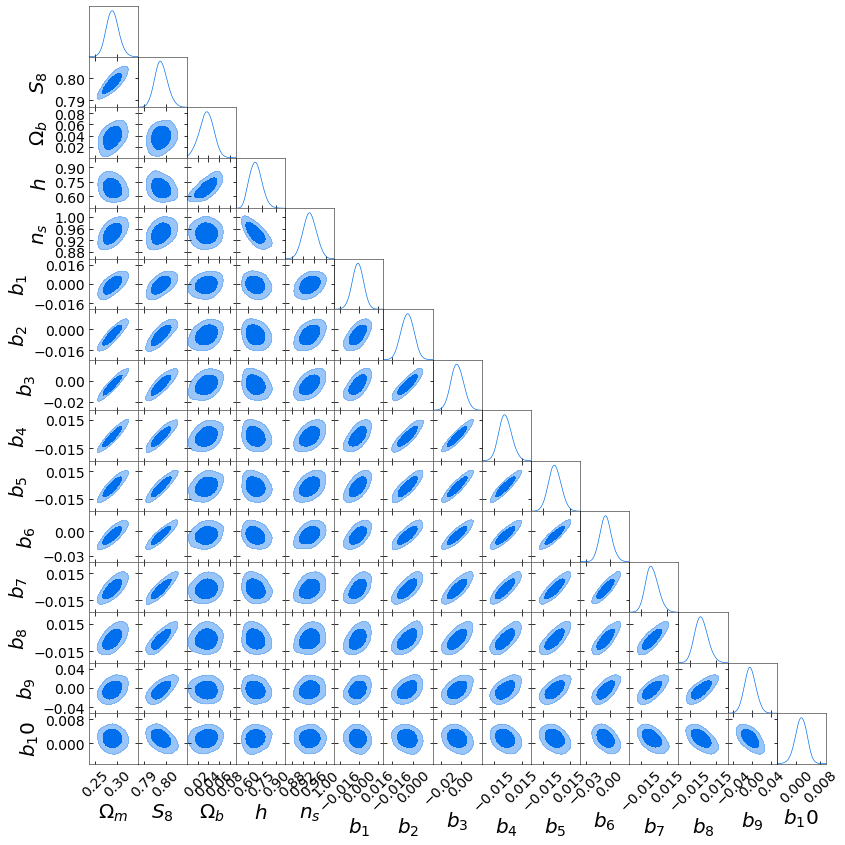

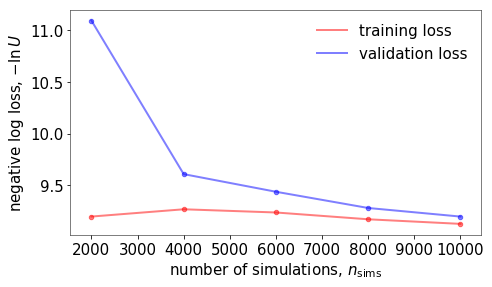

Population 5/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


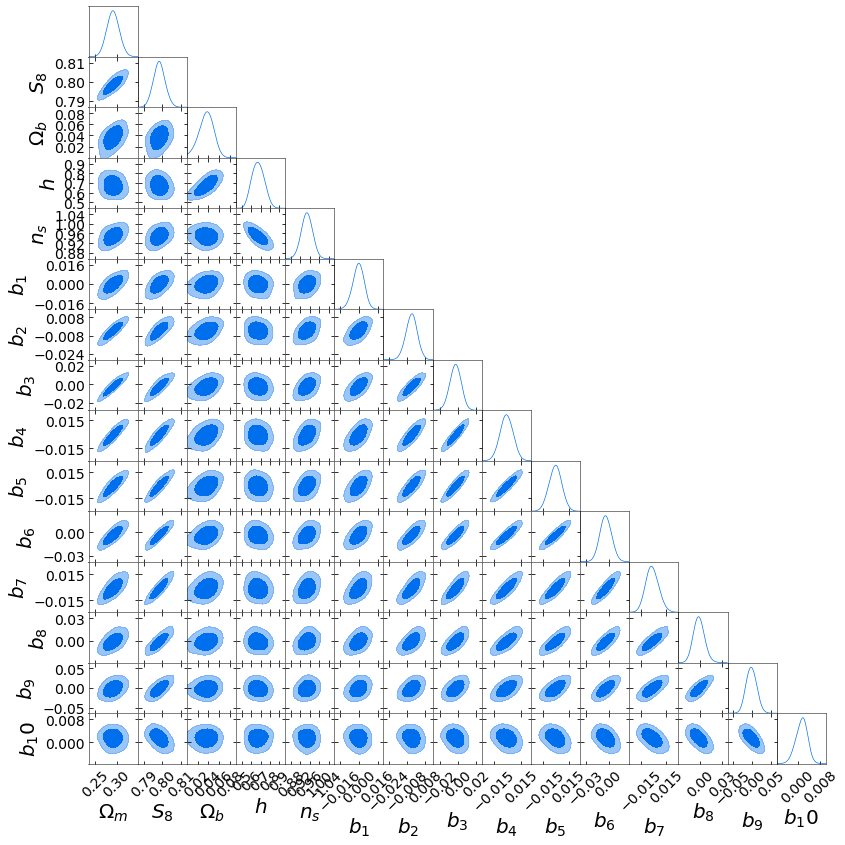

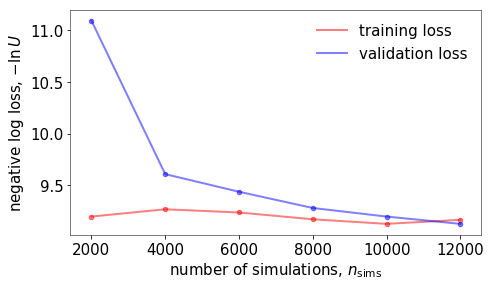

Population 6/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


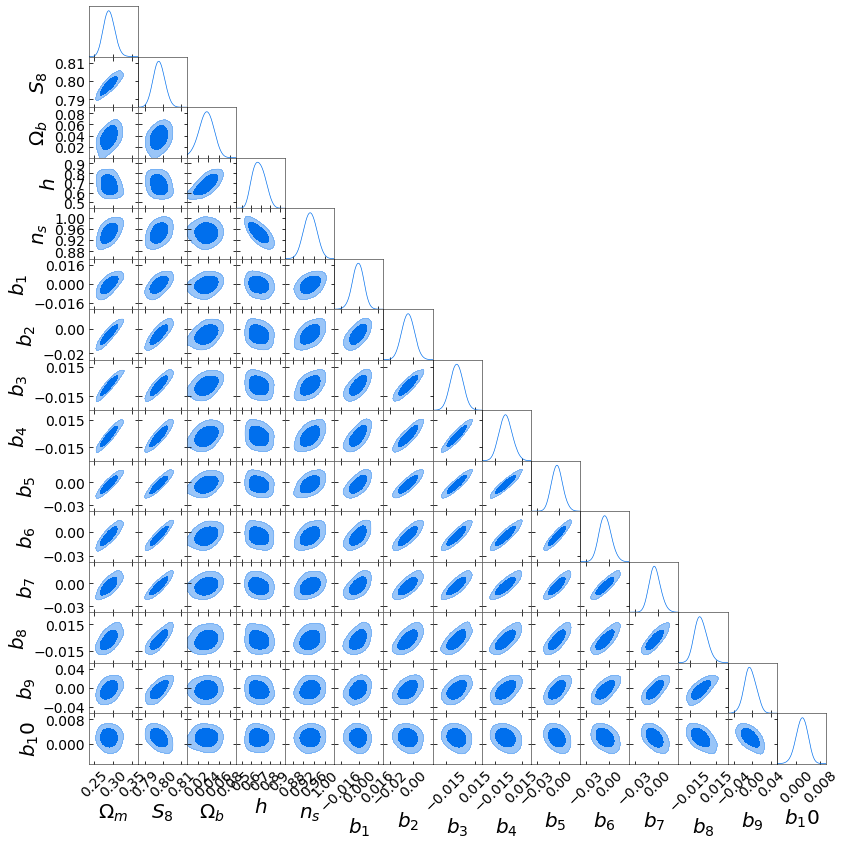

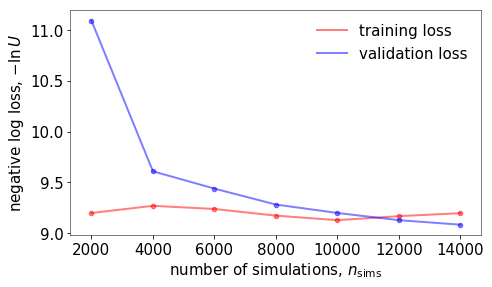

Population 7/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


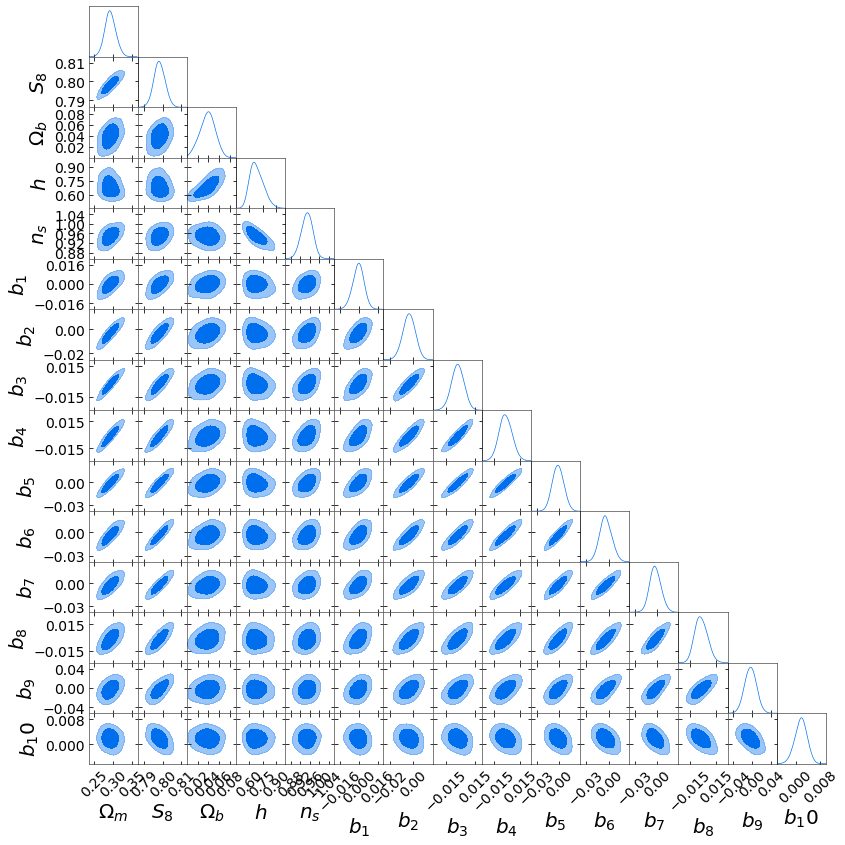

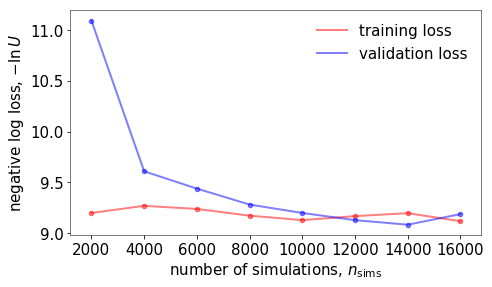

Population 8/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


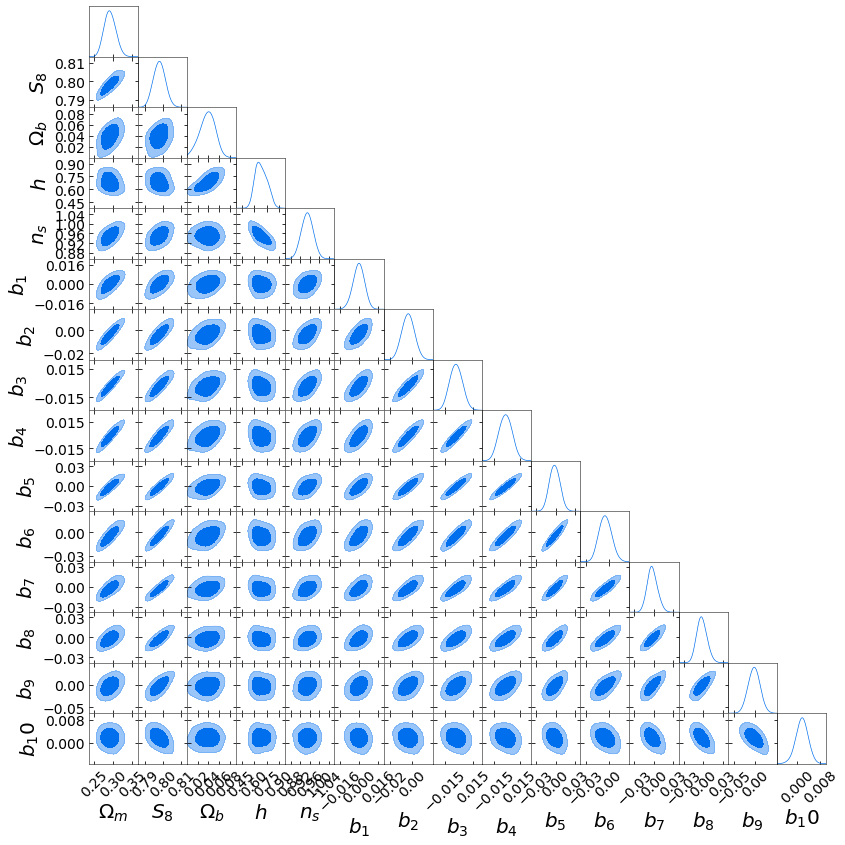

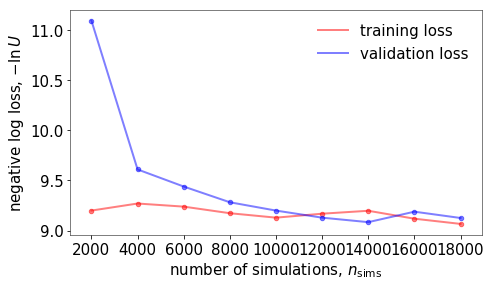

Population 9/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


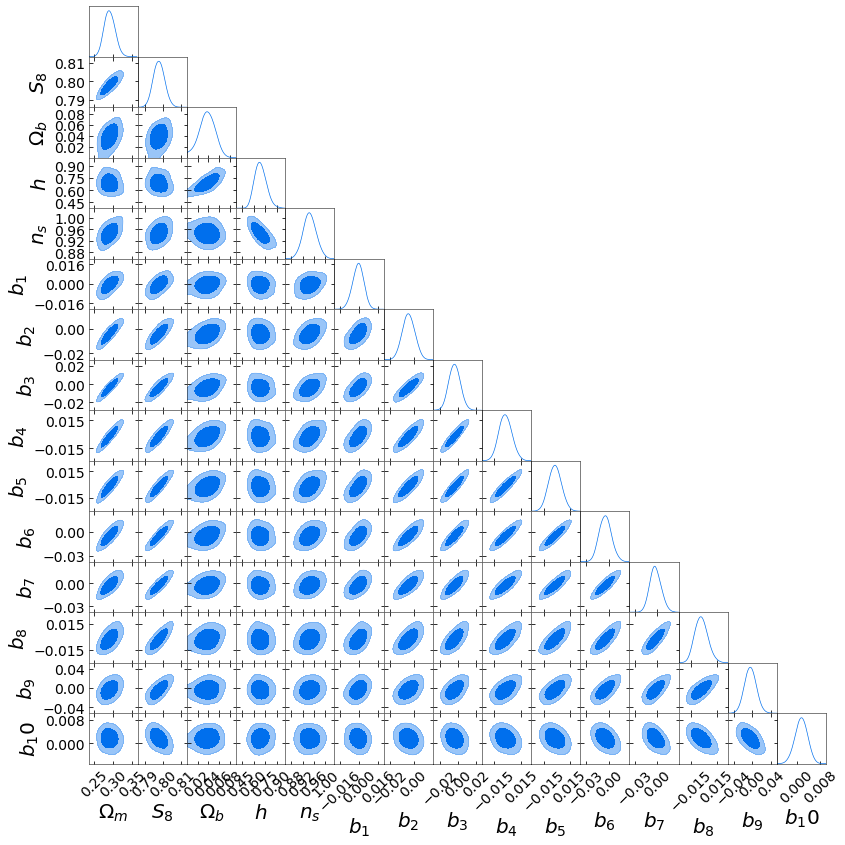

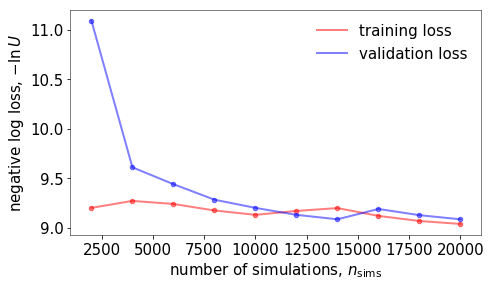

Population 10/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


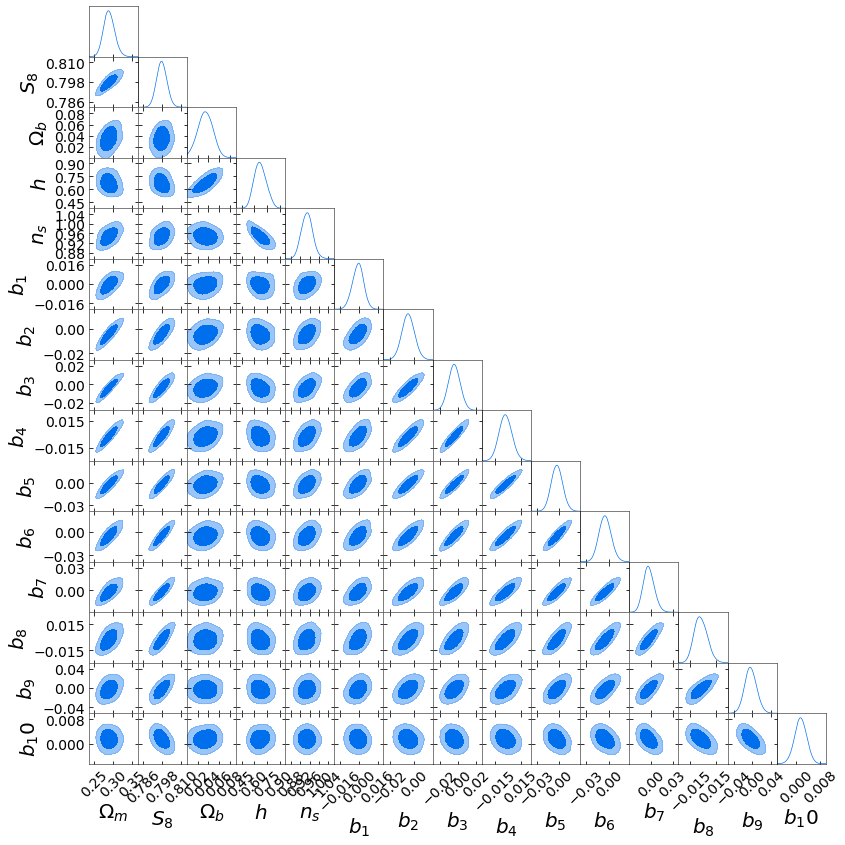

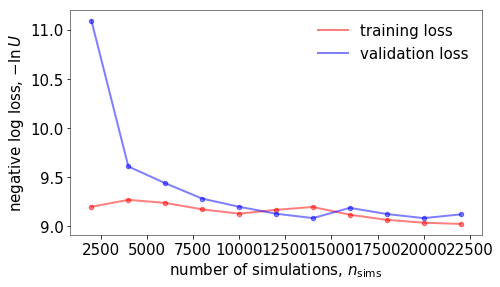

Population 11/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


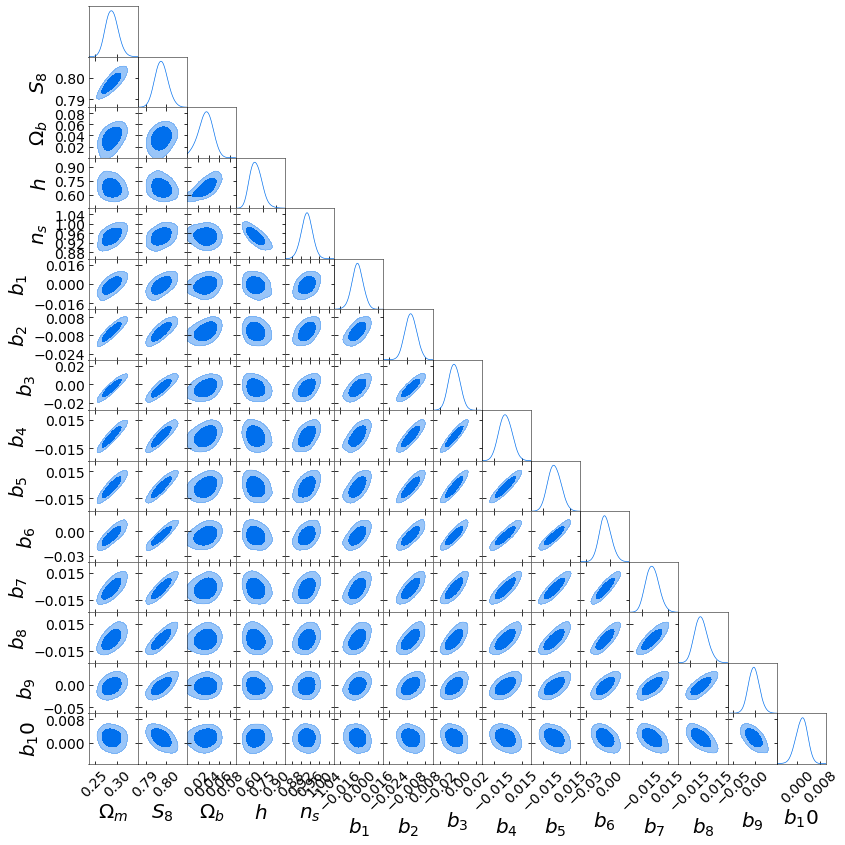

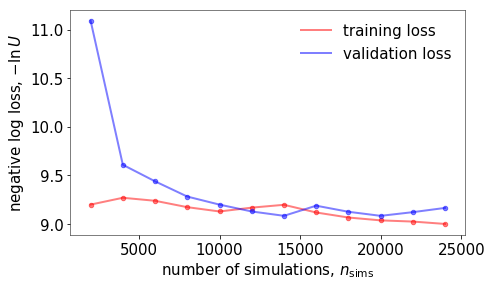

Population 12/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


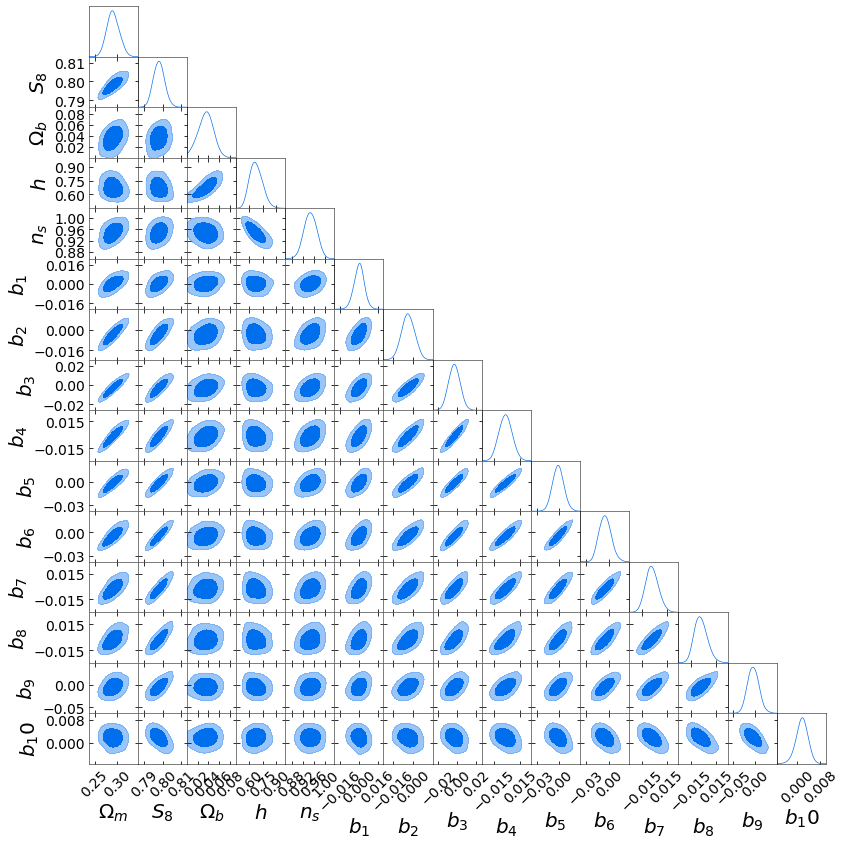

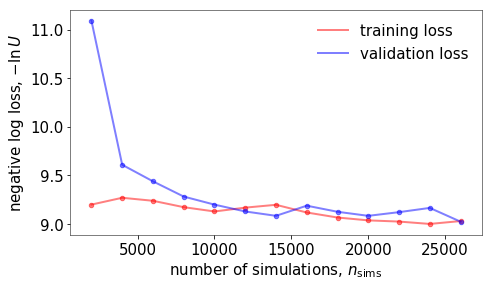

Population 13/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


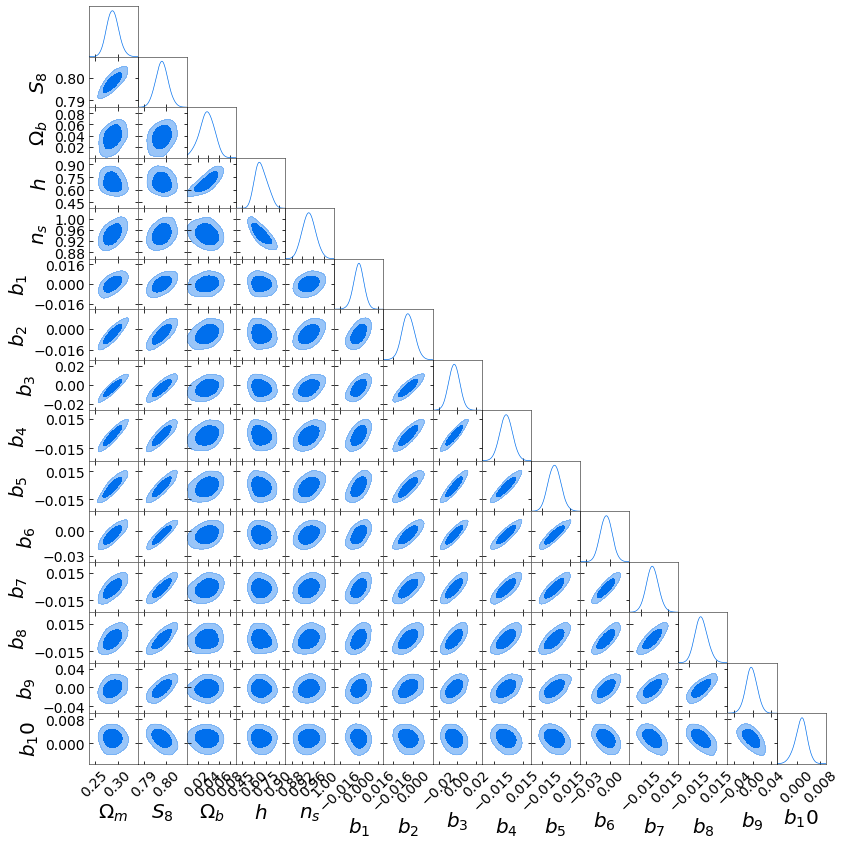

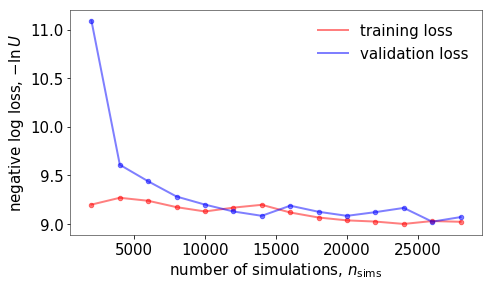

Population 14/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


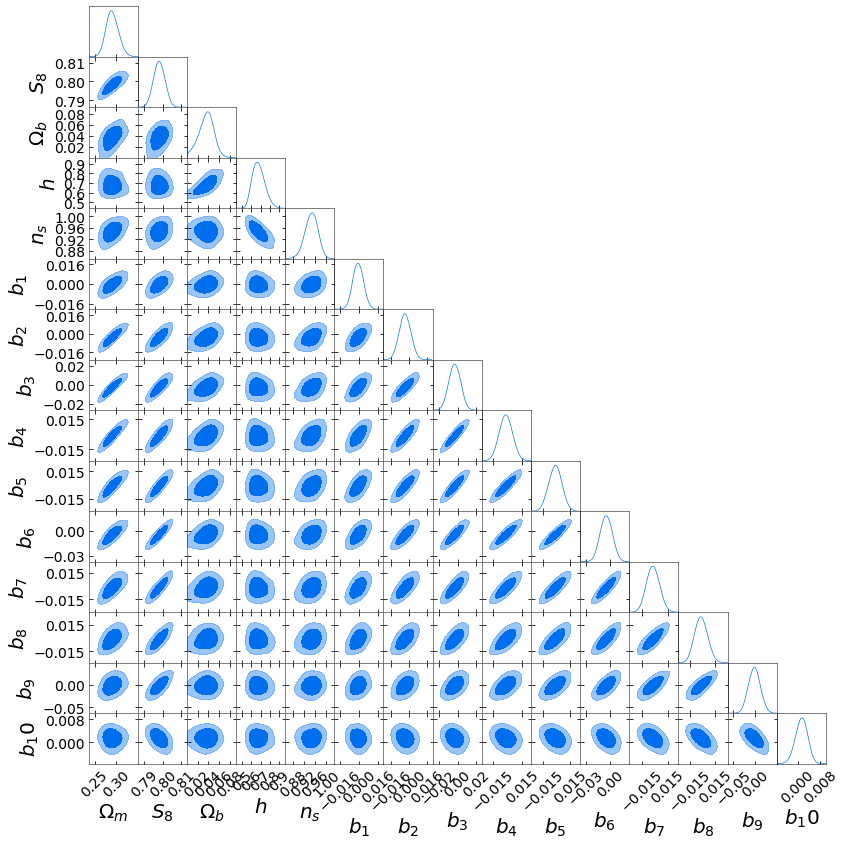

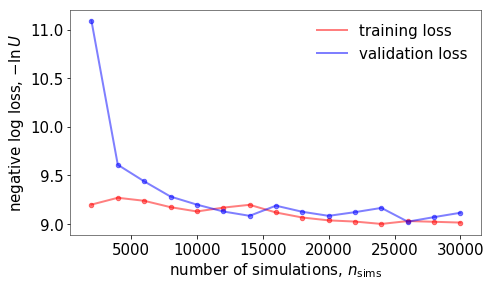

Population 15/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


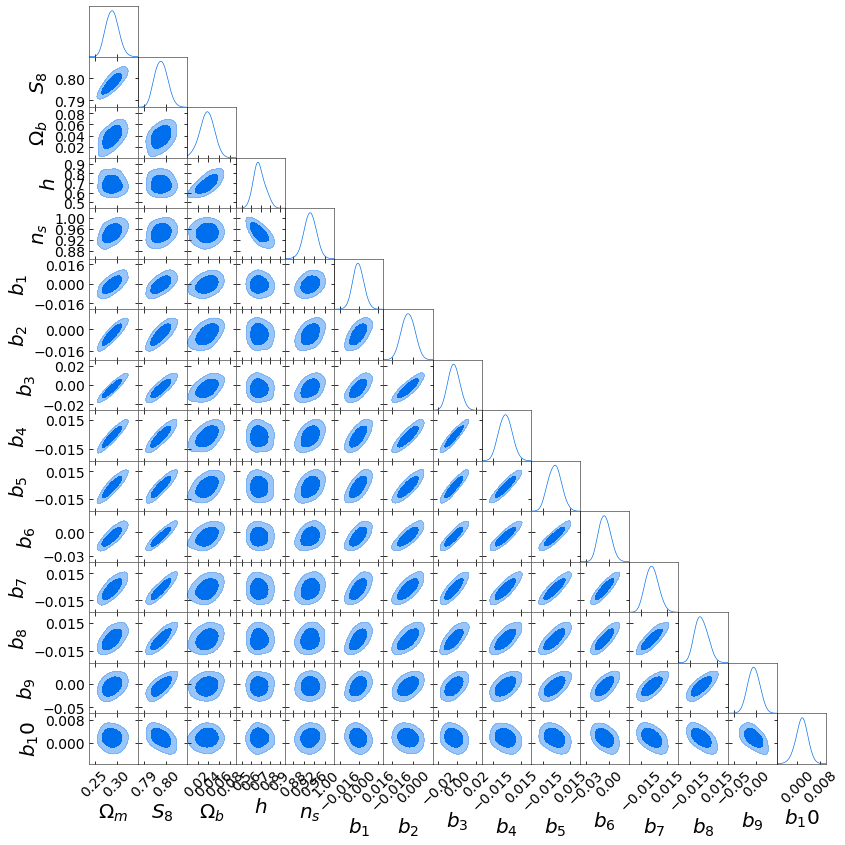

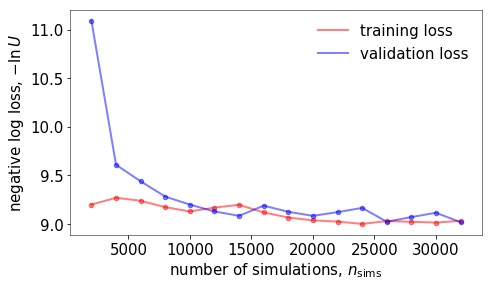

Population 16/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


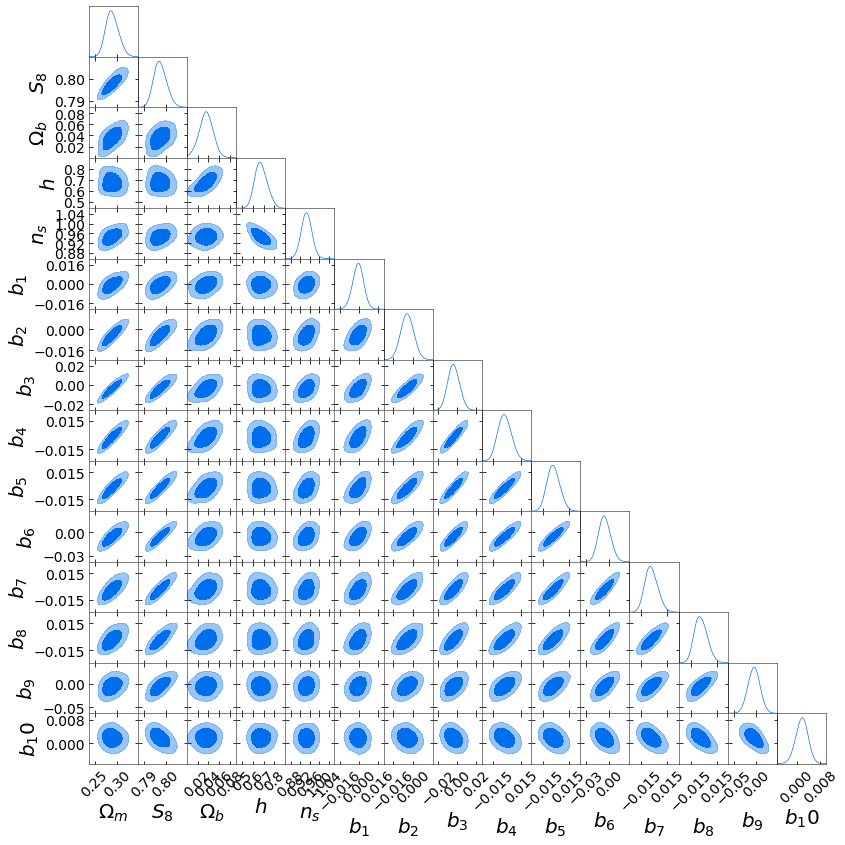

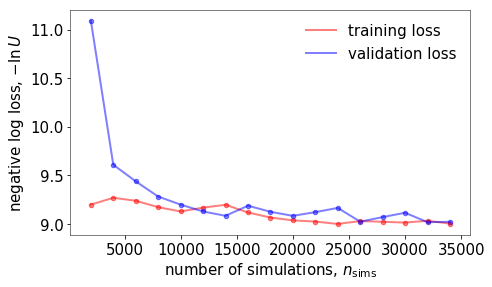

Population 17/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


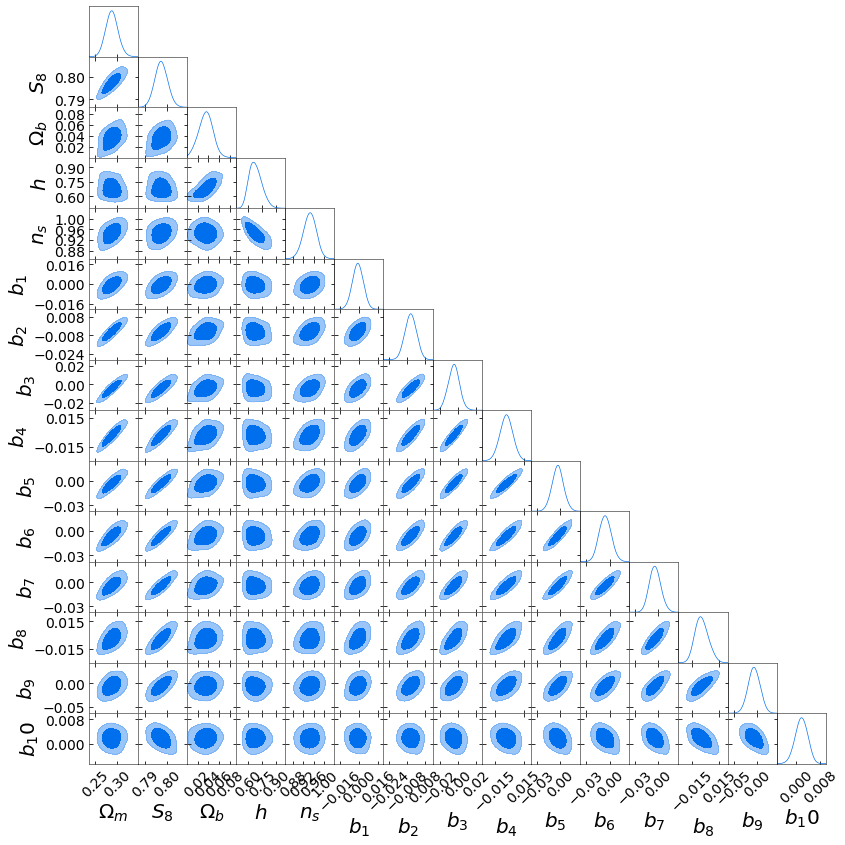

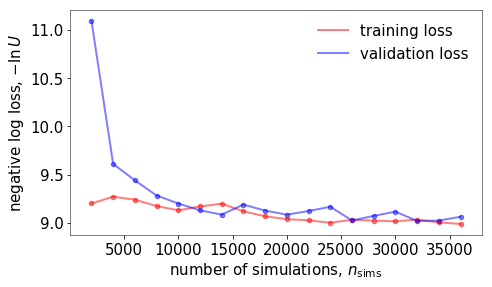

Population 18/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


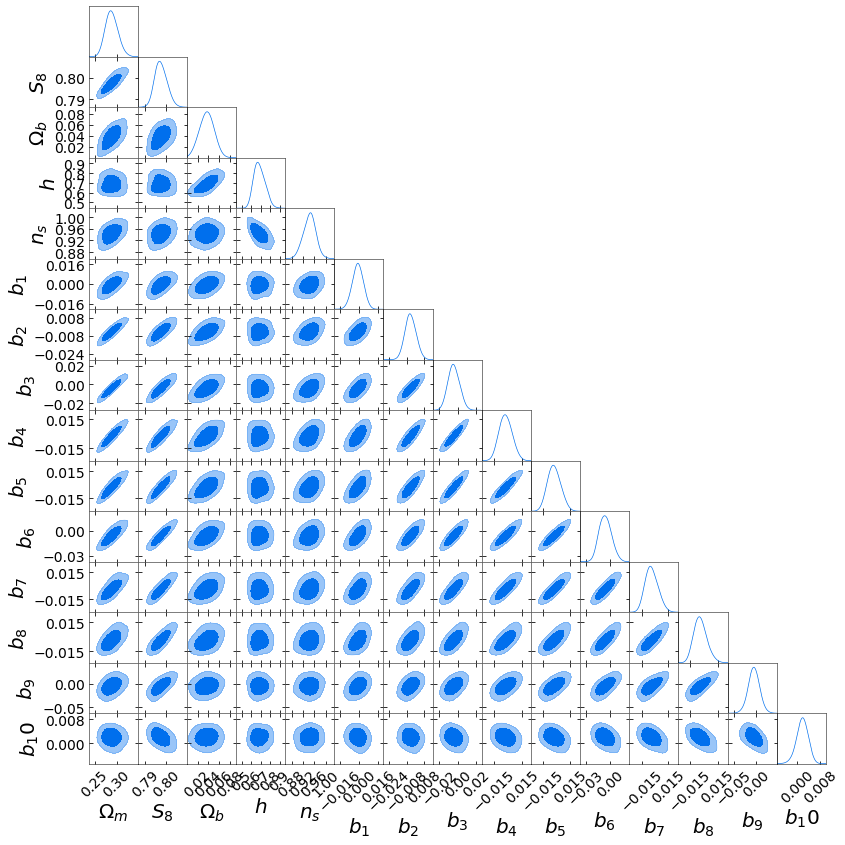

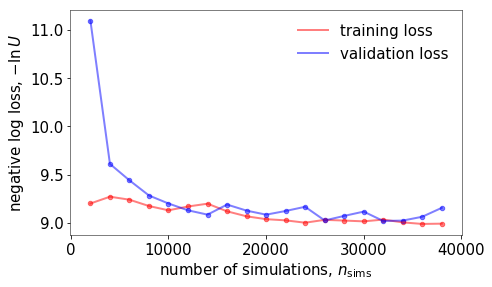

Population 19/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


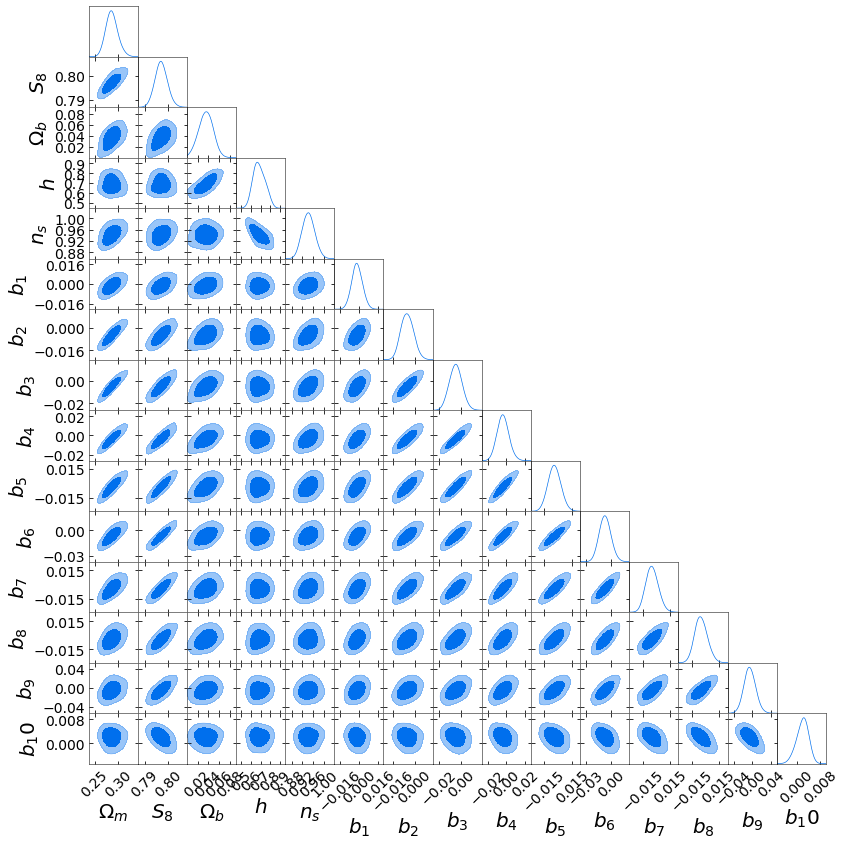

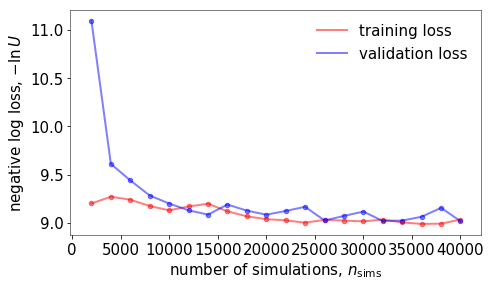

Population 20/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


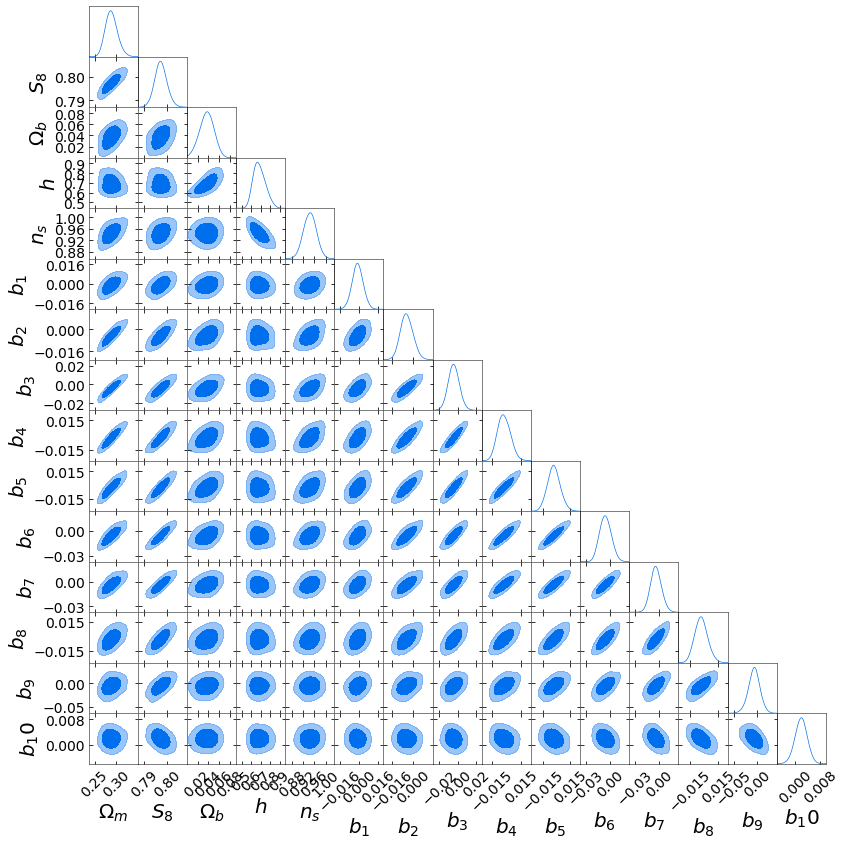

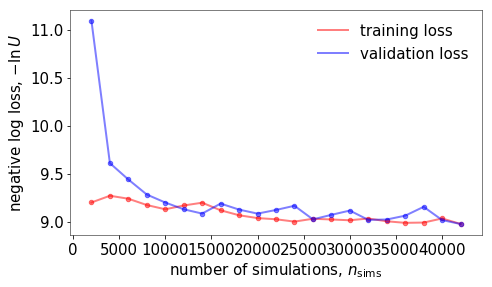

Population 21/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


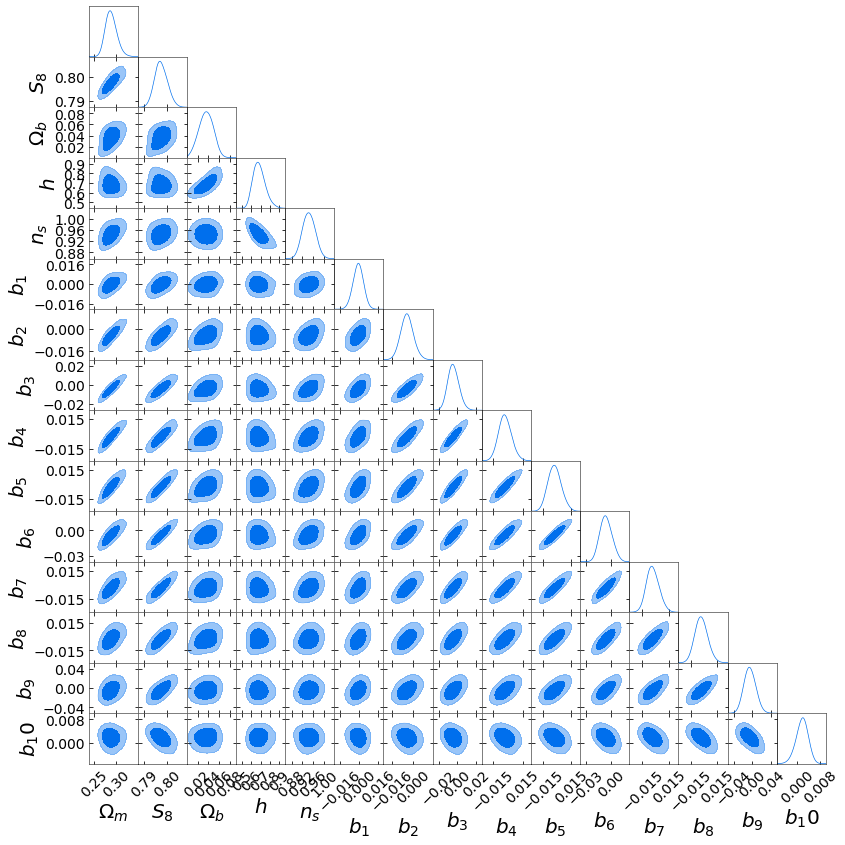

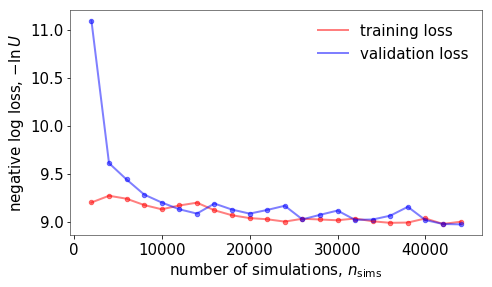

Population 22/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


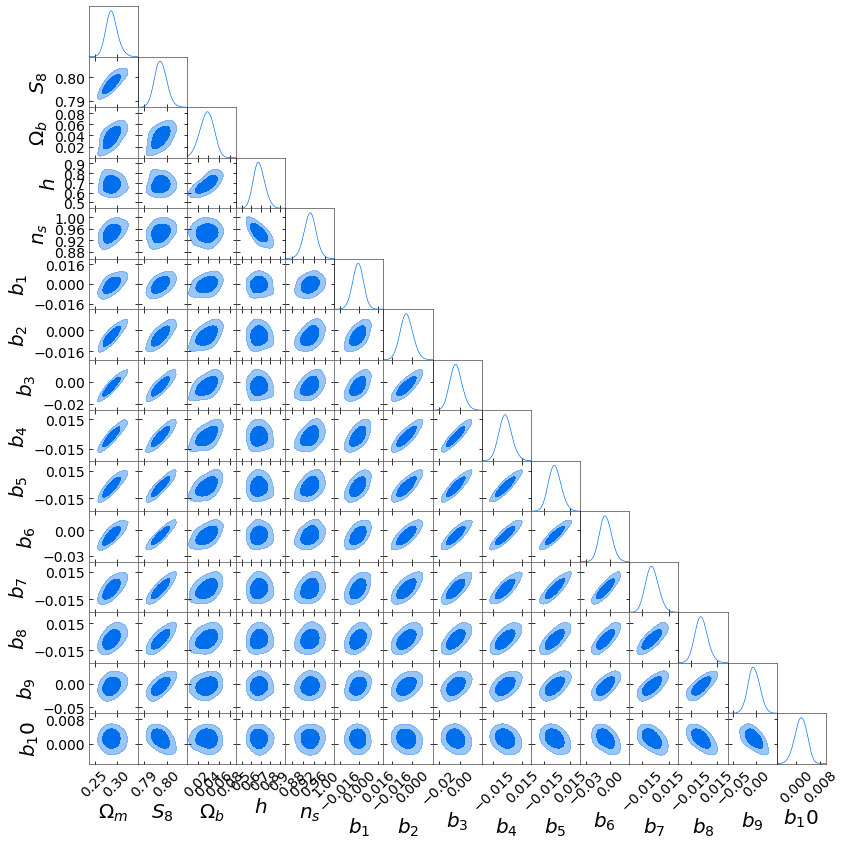

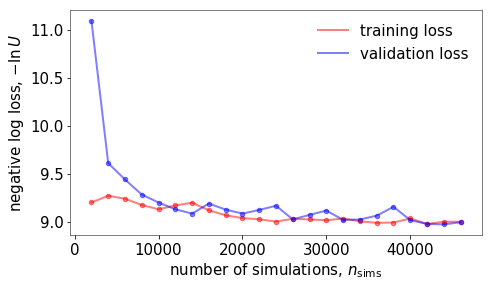

Population 23/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


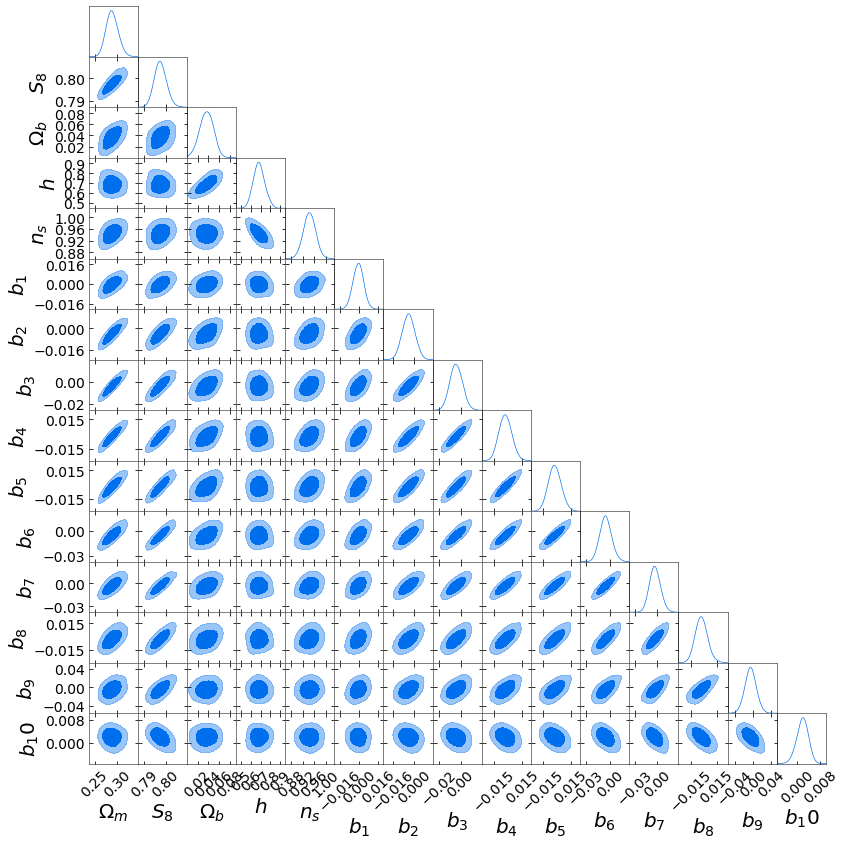

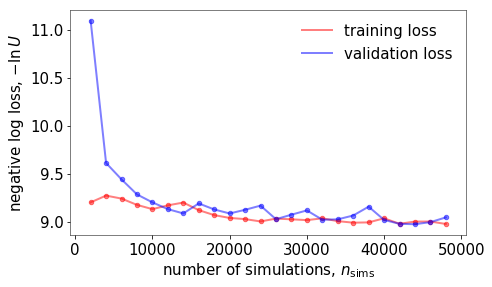

Population 24/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


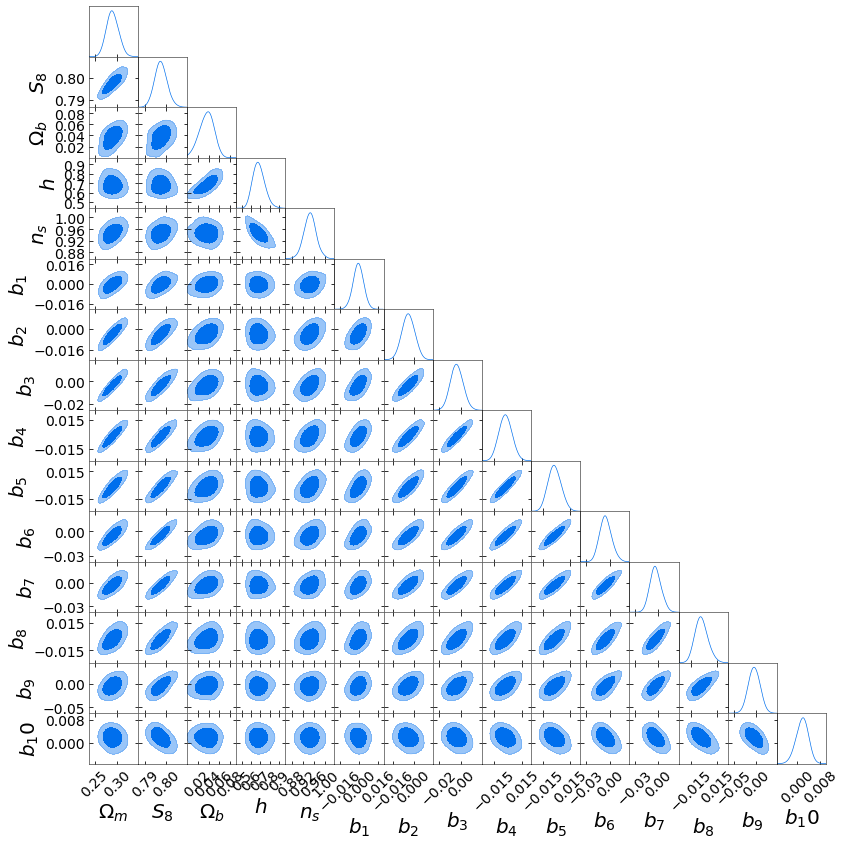

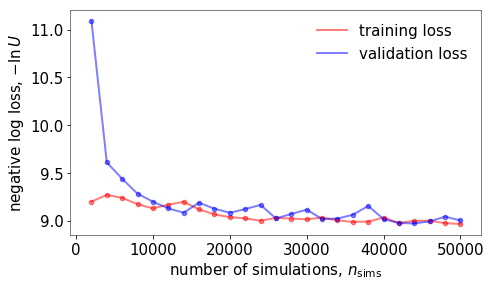

Population 25/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


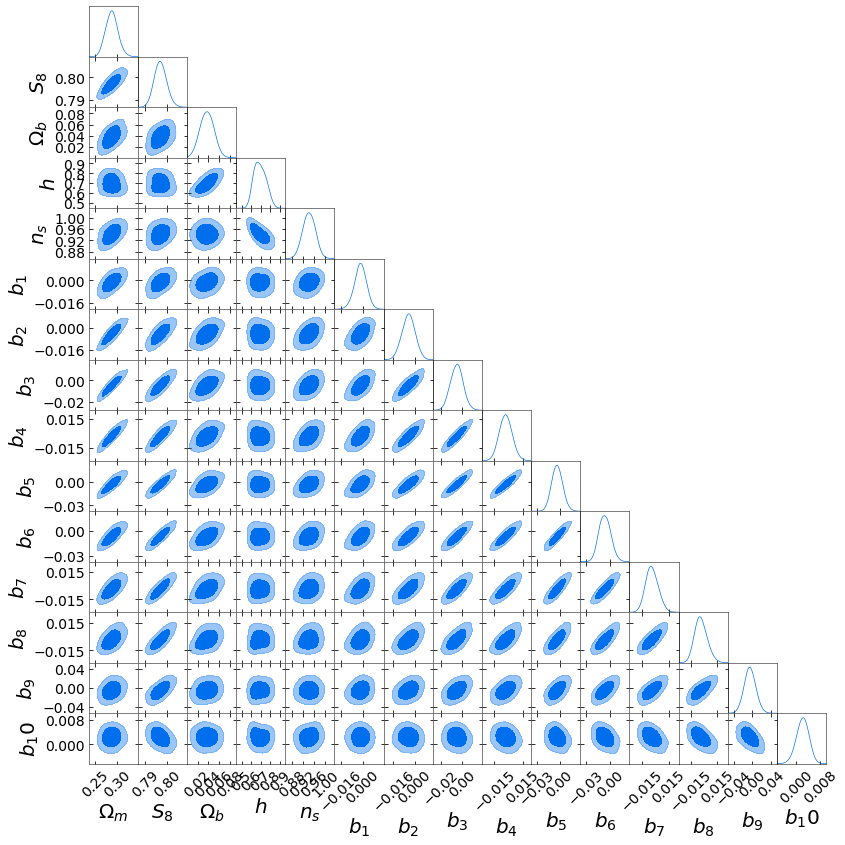

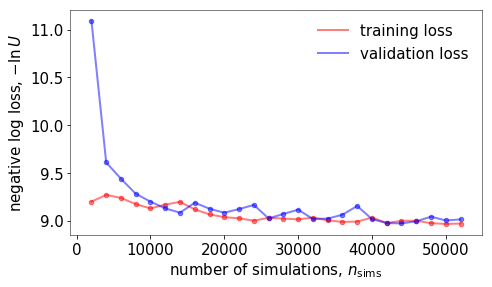

Population 26/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


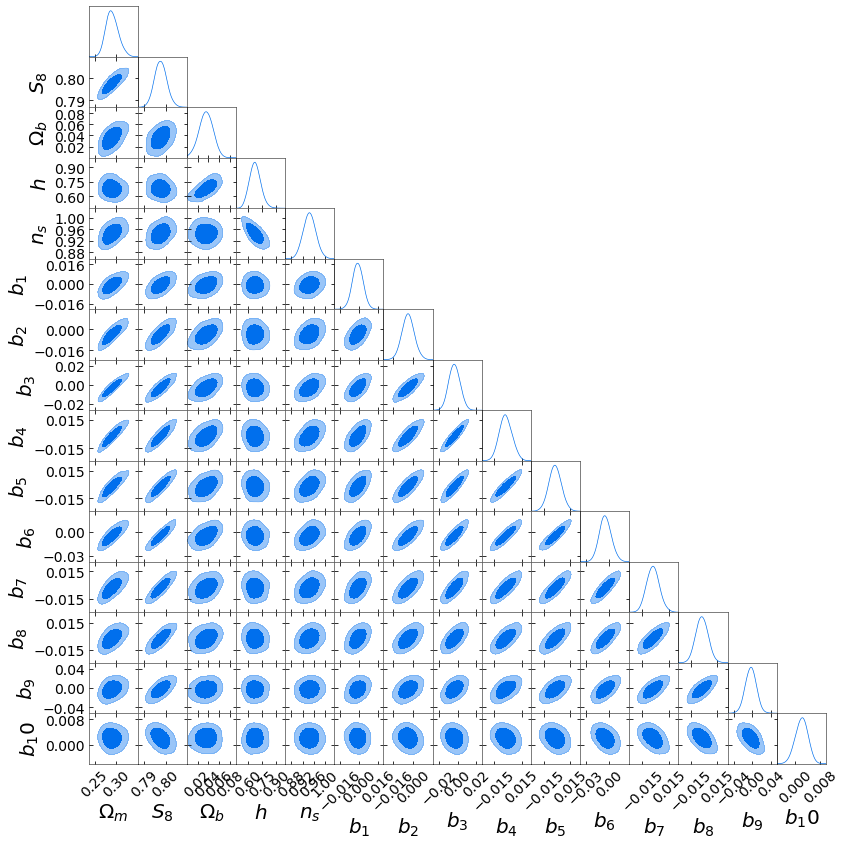

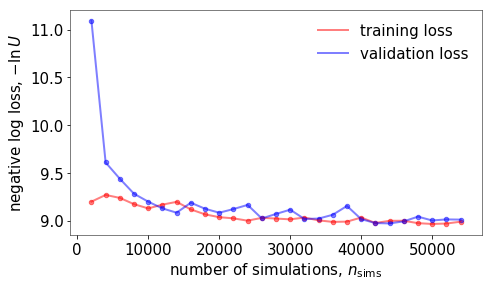

Population 27/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


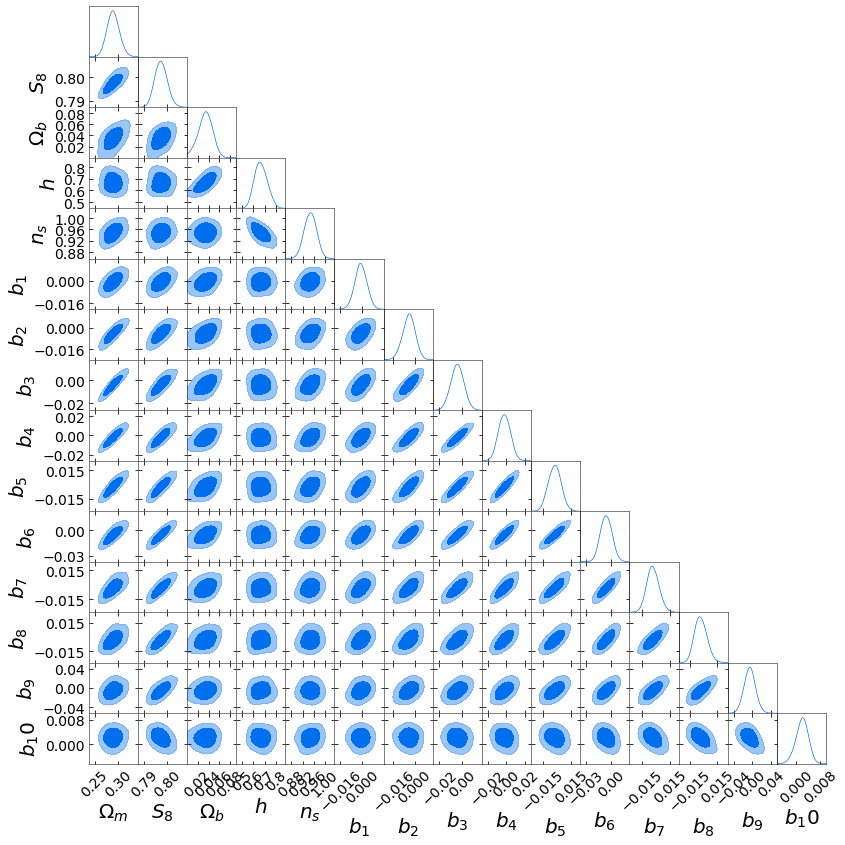

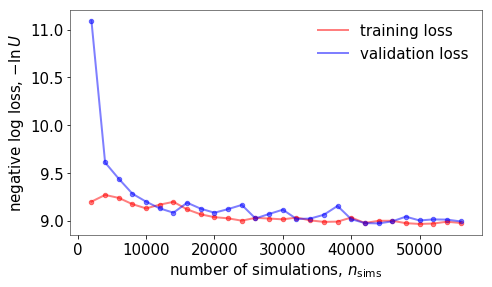

Population 28/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


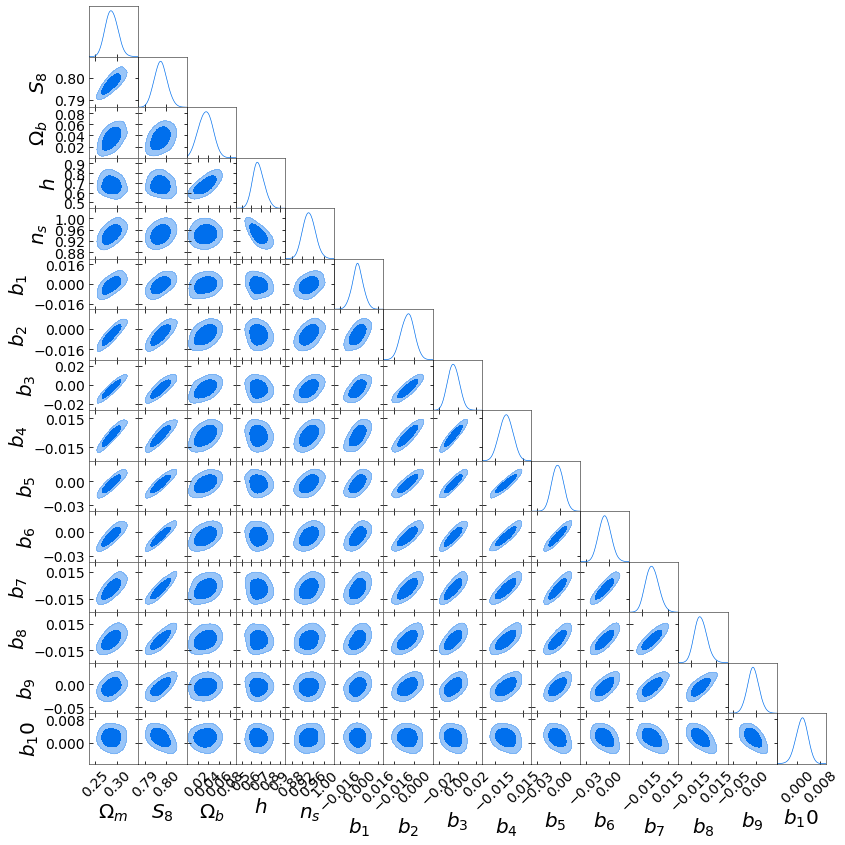

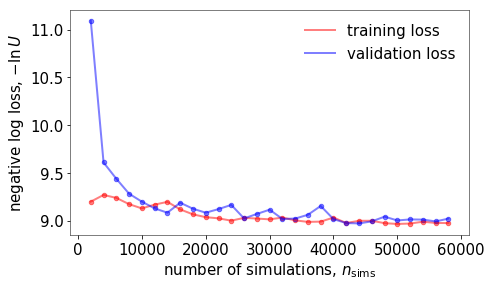

Population 29/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


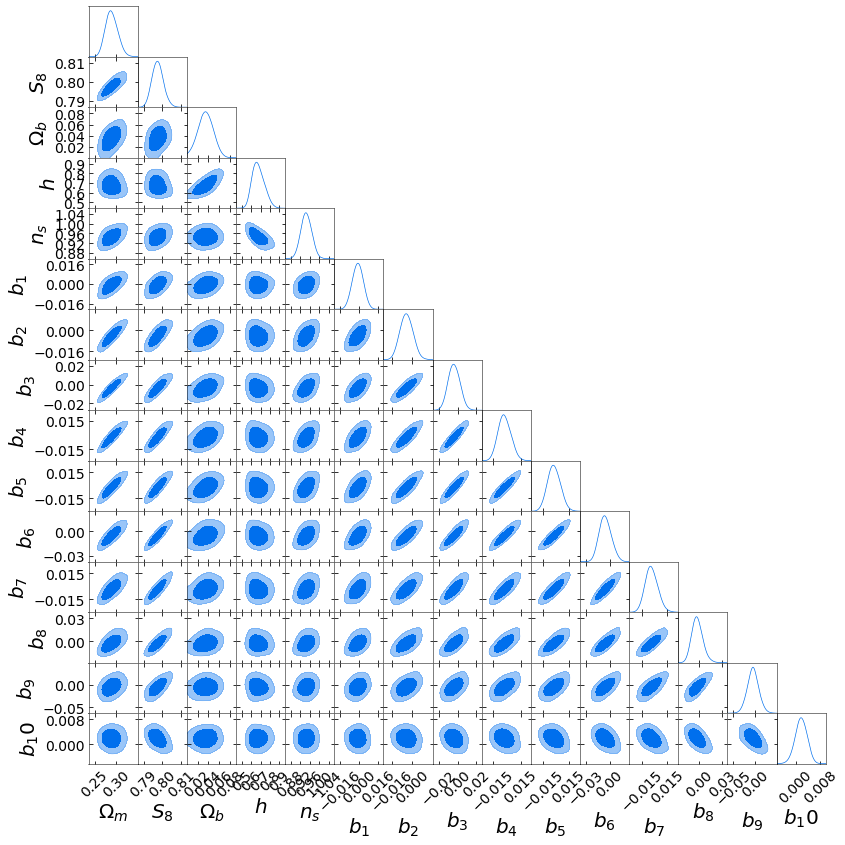

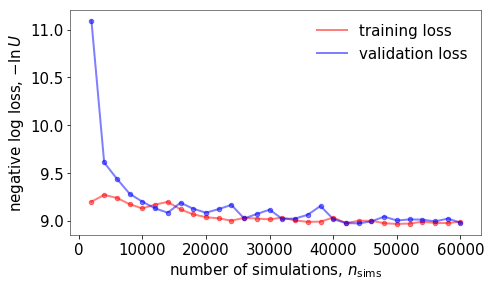

Population 30/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


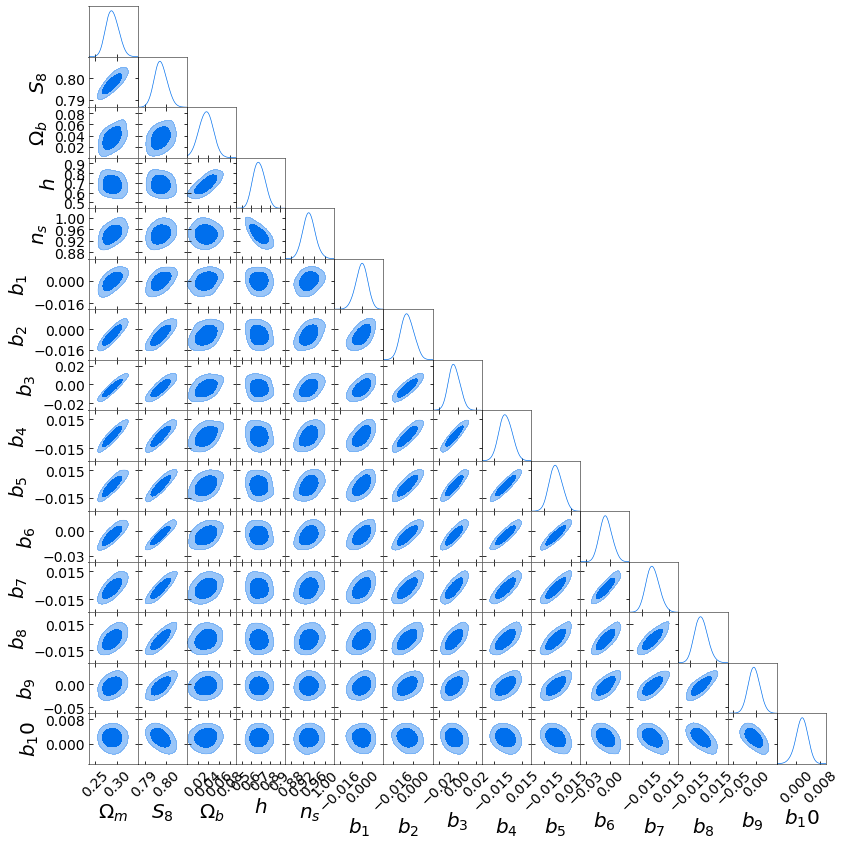

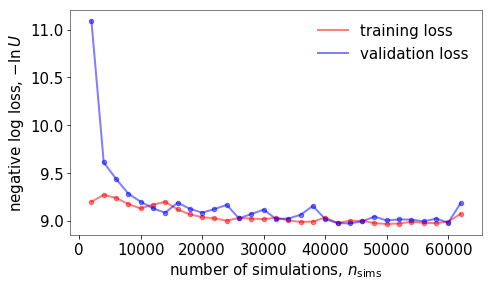

Population 31/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


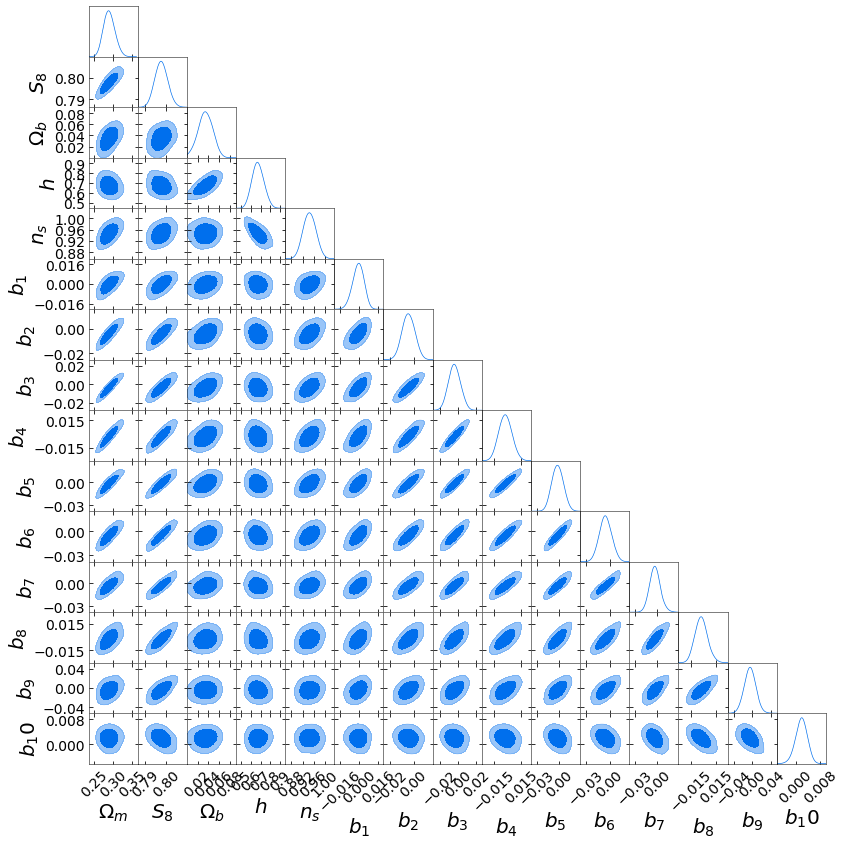

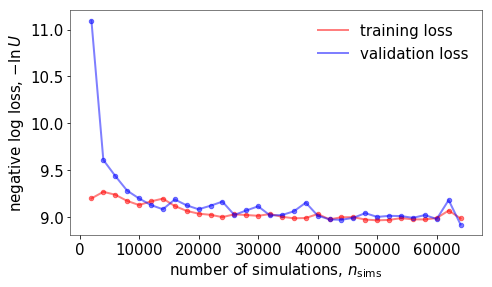

Population 32/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

Simulator returns exception for parameter values: [ 0.30595931  0.79799739  0.04640982  0.63603979  0.9939583  -0.00927219
  0.00279971  0.00337015  0.00416555  0.00672851  0.00132042  0.00229845
  0.00872743 -0.00582777  0.00397833] (rank 0)


HBox(children=(IntProgress(value=0, description='Training', max=1000), HTML(value='')))

Sampling approximate posterior...
Done.


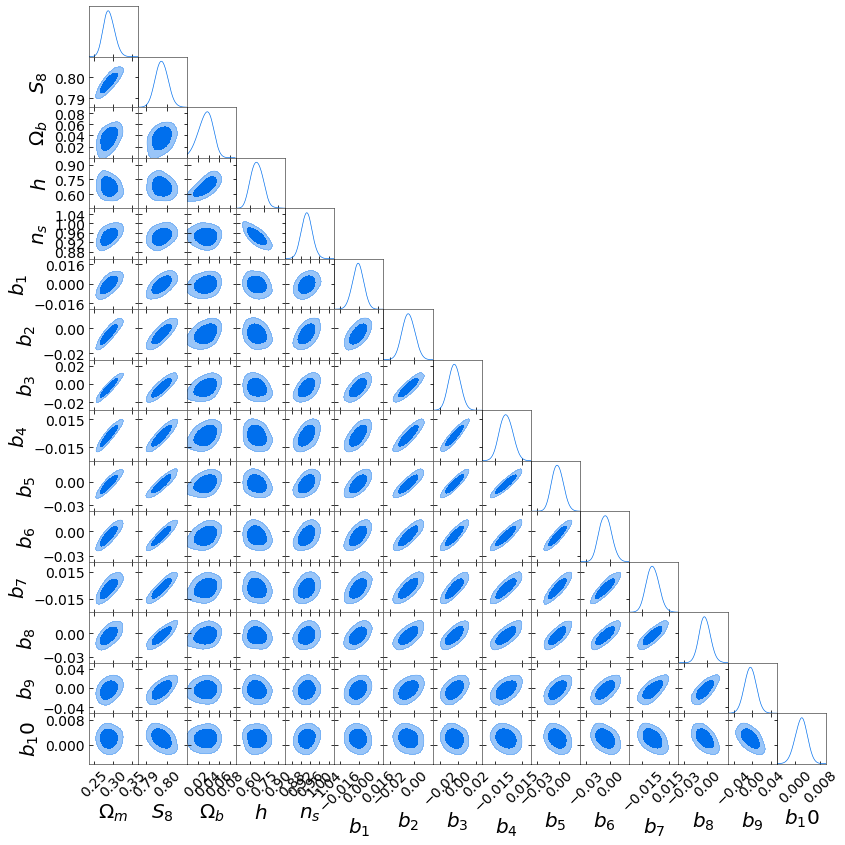

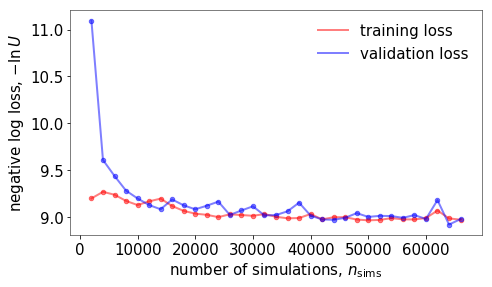

Population 33/99
Sampling proposal density...
Done.


HBox(children=(IntProgress(value=0, description='Simulations', max=1999), HTML(value='')))

Simulator returns exception for parameter values: [ 0.31648582  0.80022159  0.05134601  0.743684    0.92388382  0.00420227
  0.00446863  0.0053348   0.01265484  0.01107372  0.00458602  0.00266147
 -0.00703837  0.00474579  0.00107644] (rank 0)


In [ ]:
# Initial samples, batch size for population samples, number of populations
n_initial = 2000
n_batch = 2000
n_populations = 99

# Do the SNL training
DelfiMAF.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, simulator_args=simulator_args)